<H1 style="background-color:powderblue;">
    <center>
         Feature Map
     </center>
 </H1>

torch:
https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

1. weights - data patterns extracted from the images.
2. Different Conv2D filters are created for each of the three channels for a color image.

<H1 style="background-color:powderblue;">
    <center>
          Saliency maps
     </center>
 </H1>

https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80

<H1 style="background-color:red;">
    <center>
          Note:
     </center>
 </H1>

Remove Cat\666.jpg and Dog\11702.jpg (bad files)

In [1]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib                          import pyplot
from matplotlib.image                    import imread
from torchvision.datasets                import ImageFolder
from torch.optim.lr_scheduler            import OneCycleLR
from sklearn.metrics                     import r2_score


import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchinfo
from torchvision              import datasets
import torch
import os
import random
import matplotlib
import torchvision
import torchinfo
import gc 
import os
import time


In [3]:
oTransforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
                                # transforms.Normalize(mean=0., std=1.)]

In [4]:
DATA_PATH           = "/home/ubadmin/Lectures/OrYair/Datasets/PetImages/PetImages"
DATA_PATH           = "/home/amitli/Datasets/dogs-vs-cats/train/"
oDataSet            = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=oTransforms)
N                   = len(oDataSet)
nTrain              = 22500
nTest               = 2498
oTrainSet, oTestSet = torch.utils.data.random_split(oDataSet, [nTrain, nTest], generator=torch.Generator().manual_seed(42))

In [5]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [7]:
images, labels = next(iter(oTrainDL))
images.shape

torch.Size([256, 3, 224, 224])

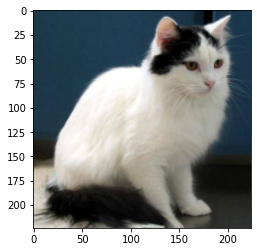

In [8]:
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))

<H1 style="background-color:powderblue;">
    <center>
          Create 2 models (smaller and larger to compare between the maps)
     </center>
 </H1>

In [10]:
def GetSmallerModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   16,  3, bias=False, stride=2), nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(16,  32,  3, bias=False, stride=2), nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),        
            
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),     
        nn.Linear           (64, 64),
        nn.Linear           (64, 2),        
    )
    
    return oModel

torchinfo.summary(GetSmallerModel(), (batchSize, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [256, 3, 224, 224]        --
├─Conv2d: 1-2                            [256, 16, 111, 111]       432
├─BatchNorm2d: 1-3                       [256, 16, 111, 111]       32
├─ReLU: 1-4                              [256, 16, 111, 111]       --
├─Dropout2d: 1-5                         [256, 16, 111, 111]       --
├─Conv2d: 1-6                            [256, 32, 55, 55]         4,608
├─BatchNorm2d: 1-7                       [256, 32, 55, 55]         64
├─ReLU: 1-8                              [256, 32, 55, 55]         --
├─Dropout2d: 1-9                         [256, 32, 55, 55]         --
├─Conv2d: 1-10                           [256, 64, 27, 27]         18,432
├─BatchNorm2d: 1-11                      [256, 64, 27, 27]         128
├─ReLU: 1-12                             [256, 64, 27, 27]         --
├─Drop

In [37]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   16,  3, bias=False, stride=2), nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(16,  32,  3, bias=False, stride=2), nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),        
        nn.Conv2d(64,  128,  3, bias=False, stride=2), nn.BatchNorm2d(128),  nn.ReLU(), nn.Dropout2d(0.1),        
        nn.Conv2d(128,  256,  3, bias=False, stride=2), nn.BatchNorm2d(256),  nn.ReLU(), nn.Dropout2d(0.1),        
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),     
        nn.Linear           (256, 64),
        nn.Linear           (64, 2),        
    )
    
    return oModel

torchinfo.summary(GetModel(), (batchSize, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [256, 3, 224, 224]        --
├─Conv2d: 1-2                            [256, 16, 111, 111]       432
├─BatchNorm2d: 1-3                       [256, 16, 111, 111]       32
├─ReLU: 1-4                              [256, 16, 111, 111]       --
├─Dropout2d: 1-5                         [256, 16, 111, 111]       --
├─Conv2d: 1-6                            [256, 32, 55, 55]         4,608
├─BatchNorm2d: 1-7                       [256, 32, 55, 55]         64
├─ReLU: 1-8                              [256, 32, 55, 55]         --
├─Dropout2d: 1-9                         [256, 32, 55, 55]         --
├─Conv2d: 1-10                           [256, 64, 27, 27]         18,432
├─BatchNorm2d: 1-11                      [256, 64, 27, 27]         128
├─ReLU: 1-12                             [256, 64, 27, 27]         --
├─Drop

In [11]:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [12]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
                
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)                        
            loss = Loss(mZ, vY)           
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)                
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [13]:
def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, Epoch=Epoch, sModelName='BestParams'):

    vTrainLoss   = np.full(nEpochs, np.nan)
    vTrainMetric = np.full(nEpochs, np.nan)
    vValLoss     = np.full(nEpochs, np.nan)
    vValMetric   = np.full(nEpochs, np.nan)
    vLR          = np.full(0,       np.nan)
    bestMetric   = -float('inf')

    for epoch in range(nEpochs):
        startTime                    = time.time()
        trainLoss, trainMetric, vLRi = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valMetric,   _    = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime                    = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch       :03d}:',   end='')
        print(' | Train loss: '   f'{trainLoss   :6.3f}',   end='')
        print(' | Val loss: '     f'{valLoss     :6.3f}',   end='')
        print(' | Train Metric: ' f'{trainMetric :6.3f}',   end='')
        print(' | Val Metric: '   f'{valMetric   :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime   :6.3f} |', end='')

        vTrainLoss  [epoch] = trainLoss
        vTrainMetric[epoch] = trainMetric
        vValLoss    [epoch] = valLoss
        vValMetric  [epoch] = valMetric
        vLR                 = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return vTrainLoss, vTrainMetric, vValLoss, vValMetric, vLR

<H1 style="background-color:powderblue;">
    <center>
          Train smaller model (Best: 0.821)
     </center>
 </H1>

In [14]:

nEpochs           = 30
DEVICE            = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
nIter             = nEpochs * len(oTrainDL)
Loss              = nn.CrossEntropyLoss()
Metric            = Accuracy
oSmallerModel     = GetSmallerModel     ().to(DEVICE)
oOptim            = optim.AdamW            (oSmallerModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler        = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory          = TrainModel(oSmallerModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, 
                        oOptim, oScheduler, Epoch=Epoch, sModelName='CNN-1-Smaller')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.663 | Val loss:  0.649 | Train Metric:  0.591 | Val Metric:  0.600 | epoch time: 26.516 | <-- Checkpoint!
Epoch 001: | Train loss:  0.644 | Val loss:  0.624 | Train Metric:  0.625 | Val Metric:  0.654 | epoch time: 26.387 | <-- Checkpoint!
Epoch 002: | Train loss:  0.632 | Val loss:  0.620 | Train Metric:  0.642 | Val Metric:  0.672 | epoch time: 26.981 | <-- Checkpoint!
Epoch 003: | Train loss:  0.616 | Val loss:  0.596 | Train Metric:  0.661 | Val Metric:  0.686 | epoch time: 27.319 | <-- Checkpoint!
Epoch 004: | Train loss:  0.596 | Val loss:  0.735 | Train Metric:  0.686 | Val Metric:  0.595 | epoch time: 27.282 |
Epoch 005: | Train loss:  0.589 | Val loss:  0.629 | Train Metric:  0.690 | Val Metric:  0.640 | epoch time: 27.560 |
Epoch 006: | Train loss:  0.576 | Val loss:  0.623 | Train Metric:  0.704 | Val Metric:  0.685 | epoch time

<H1 style="background-color:powderblue;">
    <center>
          Train larger model (Best: 0.872) - which is better
     </center>
 </H1>

In [14]:
nEpochs    = 30
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.CrossEntropyLoss()
Metric     = Accuracy
oModel     = GetModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, 
                        oOptim, oScheduler, Epoch=Epoch, sModelName='CNN-1')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.655 | Val loss:  0.625 | Train Metric:  0.612 | Val Metric:  0.645 | epoch time: 27.053 | <-- Checkpoint!
Epoch 001: | Train loss:  0.631 | Val loss:  0.720 | Train Metric:  0.645 | Val Metric:  0.590 | epoch time: 27.442 |
Epoch 002: | Train loss:  0.608 | Val loss:  0.566 | Train Metric:  0.675 | Val Metric:  0.717 | epoch time: 27.354 | <-- Checkpoint!
Epoch 003: | Train loss:  0.592 | Val loss:  0.914 | Train Metric:  0.691 | Val Metric:  0.560 | epoch time: 27.158 |
Epoch 004: | Train loss:  0.577 | Val loss:  0.676 | Train Metric:  0.704 | Val Metric:  0.624 | epoch time: 27.556 |
Epoch 005: | Train loss:  0.561 | Val loss:  0.534 | Train Metric:  0.715 | Val Metric:  0.738 | epoch time: 26.881 | <-- Checkpoint!
Epoch 006: | Train loss:  0.557 | Val loss:  0.723 | Train Metric:  0.719 | Val Metric:  0.582 | epoch time: 27.280 |
Epoch

<H1 style="background-color:powderblue;">
    <center>
          Load saved models
    </center>
 </H1>

In [112]:
DEVICE        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

oModel        = GetModel     ().to(DEVICE)
oModel.load_state_dict(torch.load('CNN-1.pt'))

oSmallerModel = GetSmallerModel     ().to(DEVICE)
oSmallerModel.load_state_dict(torch.load('CNN-1-Smaller.pt'))

<All keys matched successfully>

<H1 style="background-color:powderblue;">
    <center>
          Create feature map
    </center>
 </H1>

In [41]:
def get_model_layers(oModel):
    conv_layers     = []
    all_layers      = []
    model_children  = list(oModel.children())

    counter = 0
    for i in range(len(model_children)):

        if type(model_children[i]) == nn.Conv2d:

            counter+=1        
            conv_layers.  append(model_children[i])

        if type(model_children[i]) == nn.Flatten:
            break

        if hasattr(model_children[i], 'weight'):           
            all_layers.append(model_children[i]) 
            
    return conv_layers, all_layers
    

In [42]:
smaller_conv_layers, smaller_all_layers = get_model_layers(oSmallerModel)
larger_conv_layers,  larger_all_layers  = get_model_layers(oModel)

In [44]:
images, labels = next(iter(oTestDL))

torch.Size([224, 224, 3]), <class 'torch.Tensor'>


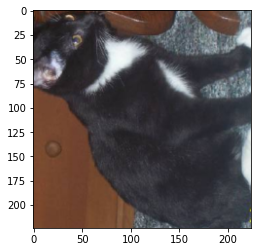

In [17]:
idx = random.randint(0,batchSize)
image = np.transpose(images[idx])
plt.imshow(image)
print(f"{image.shape}, {type(image)}")

(-0.5, 186.5, 198.5, -0.5)

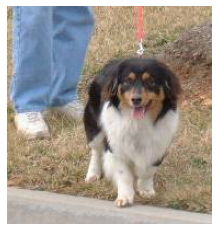

In [86]:
from PIL import Image
img_file = DATA_PATH + "/Dogs/dog.2.jpg"
image    = Image.open(img_file)
image_f  = Image.open(img_file)
plt.imshow(image)
plt.axis('off')

In [87]:
image = oTransforms(image)
image = image.unsqueeze(0)
image = image.to(DEVICE)


In [88]:
def process(layer_outputs):
       
    processed = []
    for feature_map in layer_outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())  
        
    return processed

In [89]:
def create_feature_maps(image, conv_layers, all_layers):
        
    input_image_cnn =  image.clone().detach()
    input_image_all =  image.clone().detach()
    
    all_outputs = []
    all_names   = []

    cnn_outputs = []
    cnn_names   = []

    for layer in conv_layers[0:]:
        input_image_cnn = layer(input_image_cnn)

        cnn_outputs.append(input_image_cnn)
        cnn_names.  append(str(layer))

    for layer in all_layers[0:]:     
        input_image_all = layer(input_image_all)    

        all_outputs.append(input_image_all)
        all_names.  append(str(layer))    
     
    processed_cnn = process(cnn_outputs)
    processed_all = process(all_outputs)

    return processed_cnn, cnn_names, processed_all, all_names

In [90]:
smaller_processed_cnn, smaller_cnn_names, smaller_processed_all, smaller_all_names = create_feature_maps(image,
                                                                     smaller_conv_layers, 
                                                                     smaller_all_layers)

larger_processed_cnn, larger_cnn_names, larger_processed_all, larger_all_names = create_feature_maps(image,
                                                                 larger_conv_layers, 
                                                                 larger_all_layers)

In [91]:
def plot_feature_map(processed_layers, layer_names):
    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed_layers)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed_layers[i])
        a.axis("off")  
        name = layer_names[i].partition("(")[0]
        a.set_title(f"{name}: #{i}", fontsize=30)


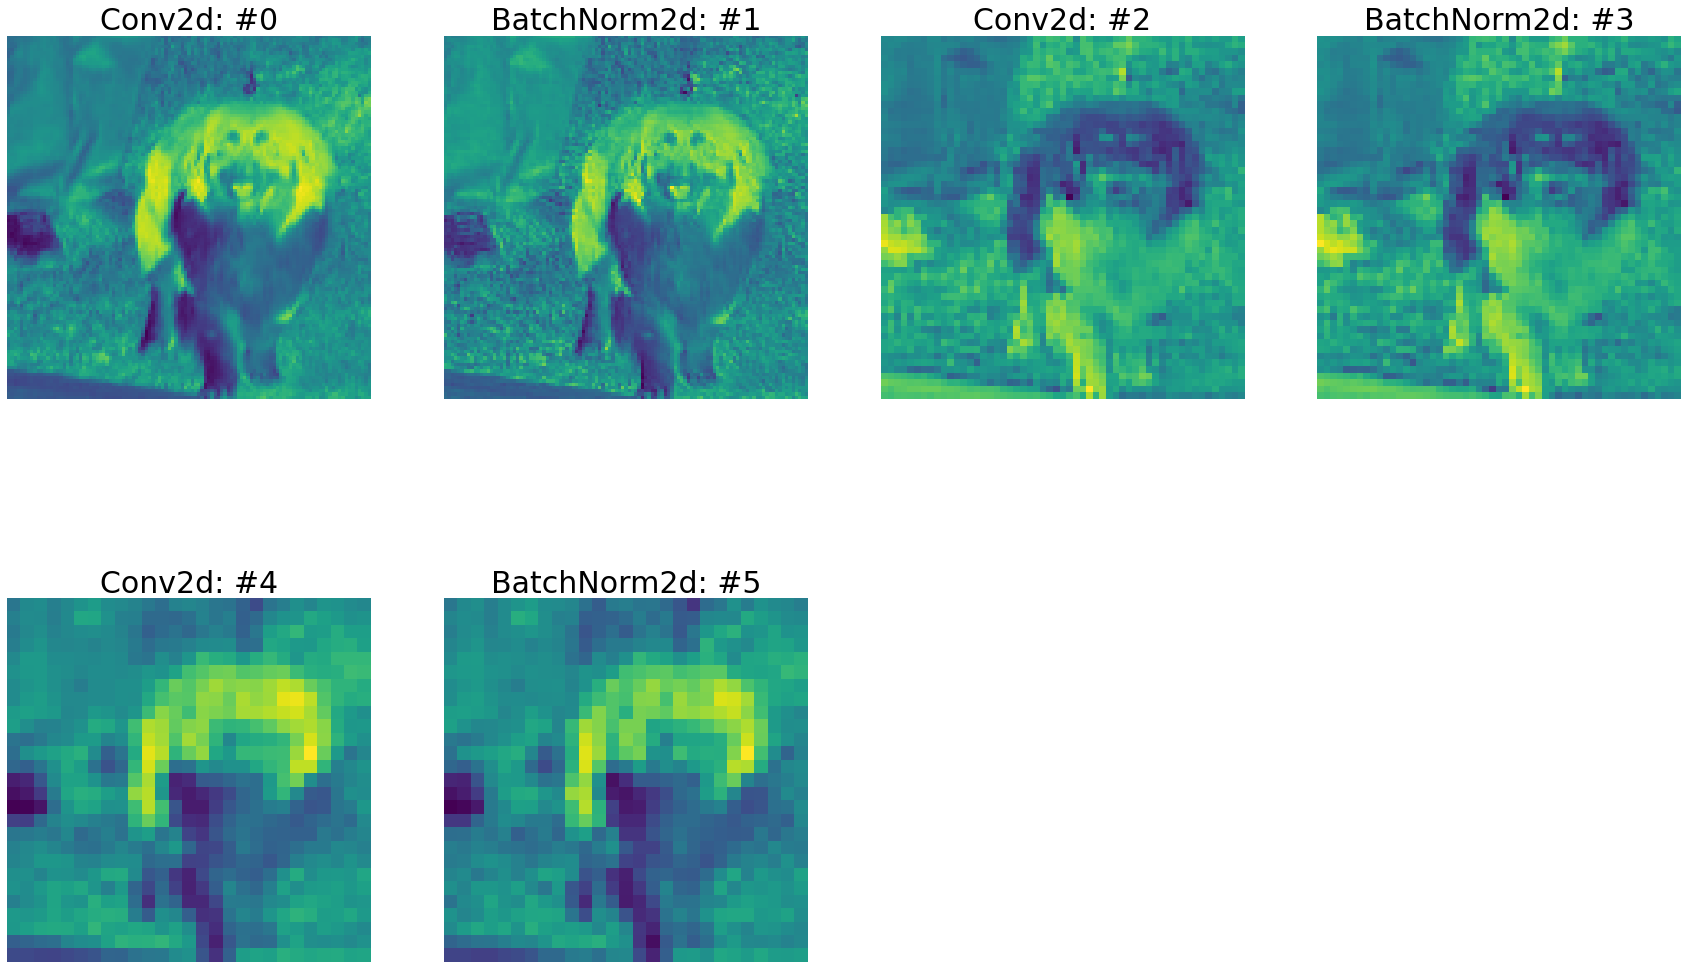

In [92]:
plot_feature_map(smaller_processed_all, smaller_all_names)

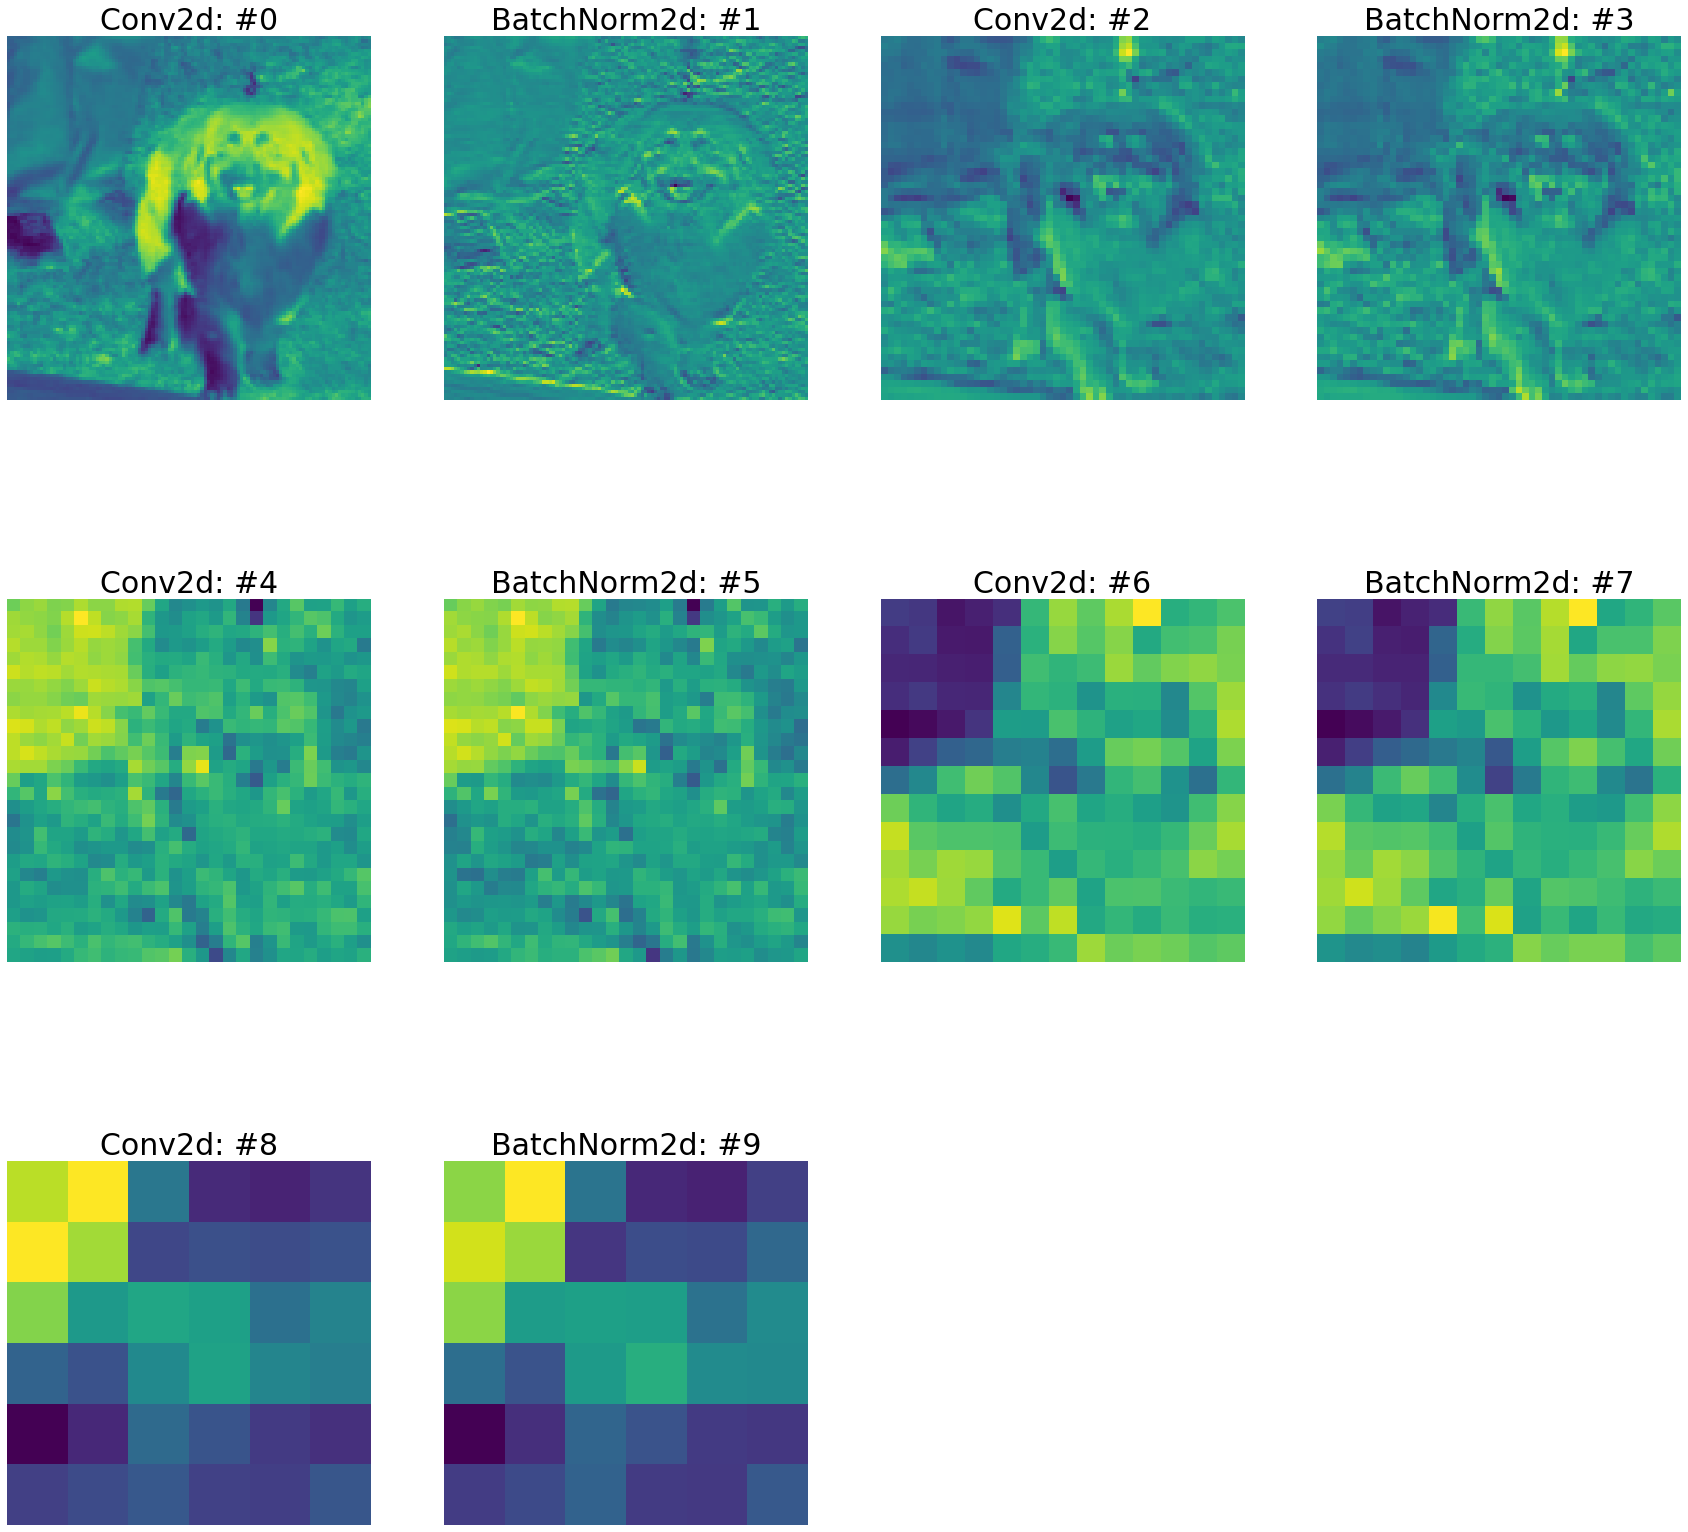

In [95]:
plot_feature_map(larger_processed_all, larger_all_names)

<H1 style="background-color:powderblue;">
    <center>
          Saliency maps
    </center>
 </H1>

(-0.5, 271.5, 334.5, -0.5)

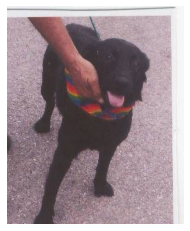

In [123]:
from PIL import Image

idx       = random.randint(0,batchSize)
img_file  = DATA_PATH + f"/Dogs/dog.{idx}.jpg"
image     = Image.open(img_file)
src_image = image.copy()
plt.imshow(src_image)
plt.axis('off')

In [118]:
def create_saliency_maps(model, image):
    

    image = oTransforms(image)
    image = image.unsqueeze(0)
    image = image.to(DEVICE)

    model.eval()
    image.requires_grad_()
    
    output = model(image)

    # Catch the output
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image
    output_max.backward()
    
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency    = saliency.reshape(224, 224)

    # Reshape the image
    image = image.reshape(-1, 224, 224)

    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()


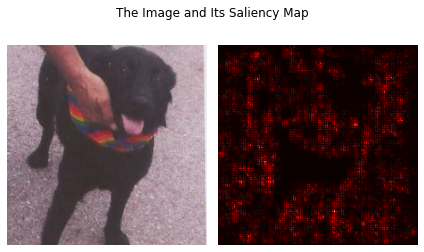

In [124]:
create_saliency_maps(oSmallerModel, src_image)

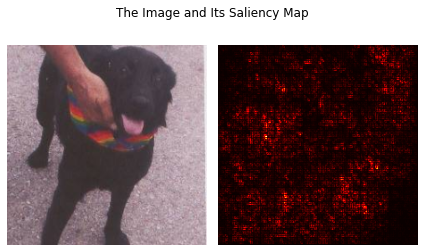

In [125]:
create_saliency_maps(oModel, src_image)